In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

## Dataset

In [4]:
# read dataset
dataset = pd.read_csv('data\\geoharmonizer_2018.csv')
dataset['date_local'] = dataset['date_local'].astype(str).str.slice(start=None, stop=-15, step=None)
dataset['date_local'] = pd.to_datetime(dataset['date_local'], format='%Y-%m-%d')

dataset_january = dataset[dataset['date_local'] == '2018-01-01']
dataset_january.head()

,country,date_local,longitude,latitude,rh_average,blh_average,tp_average,e_average,skt_average,sp_average,t2m_average,tcwv_average,ws_average,ndvi_average,elevation,nl,clc,ghaod_average,value
0,CZ,2018-01-01,14.445933,50.007305,84.865646,1425.107178,0.000006,-0.000055,280.782501,96818.351562,280.922638,9.628352,5.494684,0.1620,297.8038,255,3,0.079068,6.76
686,CZ,2018-01-01,14.442692,50.081482,83.406143,1427.938721,0.000008,-0.000057,280.919495,97087.117188,281.131134,9.673852,5.572799,0.0490,212.3033,255,1,0.086102,4.40
1018,CZ,2018-01-01,14.398141,50.073135,83.393028,1428.124878,0.000007,-0.000057,280.888214,97020.914062,281.089600,9.606381,5.606209,0.1267,250.9307,255,1,0.087150,10.80
1359,CZ,2018-01-01,14.465684,48.984386,83.262413,1086.942749,0.000003,-0.000036,279.321106,94728.750000,279.133301,9.220353,4.650469,0.1300,385.2185,255,1,0.088215,14.20
1671,CZ,2018-01-01,16.724497,48.791767,61.954552,378.895264,0.000010,-0.000027,279.185181,98651.796875,278.336273,13.108624,2.729286,0.3217,239.3933,43,2,0.084571,27.00


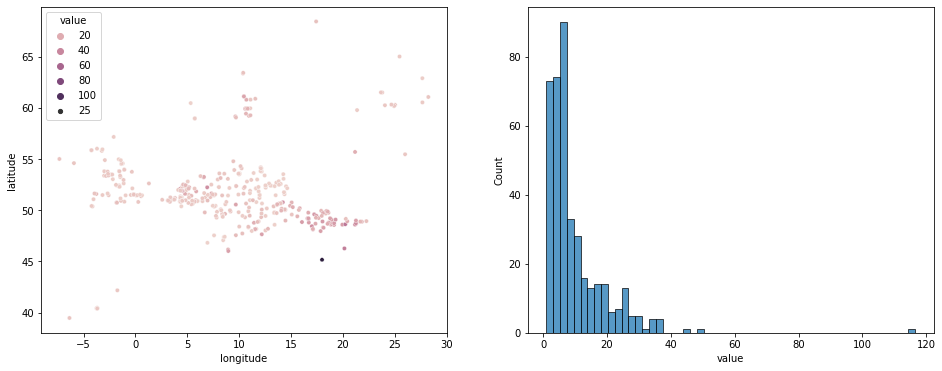

In [5]:
# visual exploration
fig, ax = plt.subplots(figsize=(16, 6), ncols=2, nrows=1)

# scatter plot of spatial distribution of samples
sns.scatterplot(data=dataset_january, x='longitude', y='latitude', hue='value', size=25, ax=ax[0])
# histogram for dependent variable (label or target)
sns.histplot(data=dataset_january, x='value', ax=ax[1])

### Processing

In [6]:
features = dataset_january.drop(['country', 'date_local', 'clc', 'nl', 'value', ], axis=1).to_numpy()
labels = dataset_january['value'].to_numpy()

In [7]:
# scale data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(features)
features_sc = scaler.transform(features)

# split data into training and testing set
from sklearn.model_selection import train_test_split

# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    features_sc, labels, test_size=0.2, random_state=42)

# get coordinates
C_train = X_train[:, :2]
C_test = X_test[:, :2]

# drop coordinates from training and testing set
X_train = X_train[:, 2:]
X_test = X_test[:, 2:]

## Models

### Standard Model - Decision tree

In [6]:
# tuning

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[None, 5, 10], 'max_features':[6, 8, 10, 12]}
dtr = DecisionTreeRegressor()
clf = GridSearchCV(dtr, parameters, cv=3)
clf.fit(X_train, y_train)

clf_res = pd.DataFrame(clf.cv_results_)

clf_res[clf_res['rank_test_score'] == 1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
4,0.001667,0.000472,0.000333,0.000471,5,6,"{'max_depth': 5, 'max_features': 6}",0.090873,0.221018,0.233463,0.181785,0.064485,1


In [7]:
# create model
dtr_model = DecisionTreeRegressor(max_depth=5, max_features=6)
dtr_model.fit(X_train, y_train)
prediction_dtr = dtr_model.predict(X_test)

In [8]:
# 
from sklearn.metrics import mean_squared_error

rmse_dtr = mean_squared_error(y_test, prediction_dtr, squared=False)
print(f'The RMSE for decision tree model is: {rmse_dtr}')

The RMSE for decision tree model is: 15.849980236694241


### Geographical model

In [9]:
# tuning 
# tuning is much more complicated and consist of several steps
# 1. We need to find, what values of bandwidth we want to test
# the bandwidth value determines how many closest samples we include in our local model
# this can be done by exploring the data
# in this case we choose several values

bandwidth = [10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 125, 150, 200, 250]

# create a matrix where we store results

result_matrix = np.zeros((C_train.shape[0], len(bandwidth)))

# 2a. Next, we need to find optimal bandwidth value for each location
# location is defined by the coordinates of training samples
# therefor we create loop for each bandwidth

for n_bandwidth_value, bandwidth_value in enumerate(bandwidth):

    # and loop for each location

    
    for n_location, location in enumerate(C_train):
        
        # 2b. For each location (training sample) we calculate the distance to other locations

        distance_matrix = np.sqrt((location[0] - C_train[:, 0])**2 + (location[1] - C_train[:, 1])**2)

        # and select indices of bandwidth_value + 1 closest distances (+1 because the search also includes distance of current location,
        # which is 0, we will discard it later).
        
        distance_indices = np.argpartition(distance_matrix, bandwidth_value+1)[:bandwidth_value+1]

        # create boolean matrix from all training samples

        boolean_matrix = np.full(C_train.shape[0], False)
        boolean_matrix[distance_indices] = True

        # lastly we discard the current sample, which is first (because the distance is 0, therefore it will be always closest)

        boolean_matrix[n_location] = False

        # 3a. Now we can construct a model, fit and test samples.

        gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=10)

        # fit the bandwidth_value closest samples

        gdtr_model.fit(X_train[boolean_matrix], y_train[boolean_matrix])

        # predict for current location (sample)

        gdtr_prediction = gdtr_model.predict(X_train[n_location].reshape(1, -1))

        # save the difference into result array
        
        result_matrix[n_location, n_bandwidth_value] = gdtr_prediction

    print(f'Loop for bandwidth {bandwidth_value} has finished.')

Loop for bandwidth 10 has finished.
Loop for bandwidth 15 has finished.
Loop for bandwidth 20 has finished.
Loop for bandwidth 25 has finished.
Loop for bandwidth 30 has finished.
Loop for bandwidth 35 has finished.
Loop for bandwidth 40 has finished.
Loop for bandwidth 50 has finished.
Loop for bandwidth 75 has finished.
Loop for bandwidth 100 has finished.
Loop for bandwidth 125 has finished.
Loop for bandwidth 150 has finished.
Loop for bandwidth 200 has finished.
Loop for bandwidth 250 has finished.


In [10]:
# 4a. Next, we evaulate the results and find the most apprioprate bandwidth value

result_rmse = []

for n_bandwidth_value, bandwidth_value in enumerate(bandwidth):

    rmse = mean_squared_error(y_train, result_matrix[:, n_bandwidth_value], squared=False)
    result_rmse.append(rmse)
    print(f'The RMSE for bandwidth value {bandwidth_value} is: {rmse}')

index_min = np.argmin(np.array(result_rmse))

print(f'The best bandwidth is {bandwidth[index_min]}')

The RMSE for bandwidth value 10 is: 9.534480170670879
The RMSE for bandwidth value 15 is: 9.863070012816136
The RMSE for bandwidth value 20 is: 9.039253938661092
The RMSE for bandwidth value 25 is: 9.462916211025377
The RMSE for bandwidth value 30 is: 9.29120368577221
The RMSE for bandwidth value 35 is: 8.441191810180754
The RMSE for bandwidth value 40 is: 8.886640351116196
The RMSE for bandwidth value 50 is: 8.702590952573534
The RMSE for bandwidth value 75 is: 9.33309876862783
The RMSE for bandwidth value 100 is: 8.838028820326764
The RMSE for bandwidth value 125 is: 9.690920112173298
The RMSE for bandwidth value 150 is: 8.870096130556659
The RMSE for bandwidth value 200 is: 10.967142059383834
The RMSE for bandwidth value 250 is: 12.66312465048995
The best bandwidth is 35


In [11]:
# 5a. we found the best bandwidth value, we can proceed to testing data
# we create a local model for each testing location

bandwidth_value = 40

# list for prediction 
prediction = []

for n_location, location in enumerate(C_test):

    # 5b calculate the distances to training samples
    distance_matrix = np.sqrt((location[0] - C_train[:, 0])**2 + (location[1] - C_train[:, 1])**2)

    # find closest SAMPLES
    distance_indices = np.argpartition(distance_matrix, bandwidth_value)[:bandwidth_value]

    boolean_matrix = np.full(C_train.shape[0], False)
    boolean_matrix[distance_indices] = True
    
    gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=8)
    gdtr_model.fit(X_train[boolean_matrix], y_train[boolean_matrix])
    gdtr_prediction = gdtr_model.predict(X_test[n_location].reshape(1, -1))
    
    prediction.append(gdtr_prediction)

In [12]:
# calculate final rmse

rmse = mean_squared_error(y_test, np.array(prediction), squared=False)

print(f'RMSE for Geographical model is: {rmse}')

RMSE for Geographical model is: 9.42781270920169


### Multiscale Geographical model

In [13]:
# the idea of multiscale Geographical model is that bandwidth may be different for every predicted place
# in comparision to geographical model, where is one "universal" bandwidth value

# 1a. find best bandwidth value for each training location

difference = np.zeros(result_matrix.shape)

for n_b in range(len(bandwidth)):

    difference[:, n_b] = np.sqrt((result_matrix[:, n_b] - y_train)**2)

best_bandwidth = np.array(list(map(lambda x: bandwidth[x], np.argmin(difference, axis=1))))

In [14]:
# 2a. new prediction are made for each test sample in a loop

# list for prediction 
prediction = []

for n_location, location in enumerate(C_test):

    # 2b. to each tested sample is assigned bandwidth value from closest trained sample
    # calculate a distance matrix

    distance_matrix = np.sqrt((location[0] - C_train[:, 0])**2 + (location[1] - C_train[:, 1])**2)

    # find index of closest training sample
    bandwidth_index = np.argmin(distance_matrix)

    # find bandwidth value
    closest_bandwidth = best_bandwidth[bandwidth_index]
    
    # 2c. get the indices of closest_bandwidth value training samples

    distance_indices = np.argpartition(distance_matrix, closest_bandwidth)[:bandwidth_value]

    # and create a boolean matrix 
    boolean_matrix = np.full(C_train.shape[0], False)
    boolean_matrix[distance_indices] = True

    # 3a. create a model
    gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=8)
    # fit
    gdtr_model.fit(X_train[boolean_matrix], y_train[boolean_matrix])
    # and predict
    gdtr_prediction = gdtr_model.predict(X_test[n_location].reshape(1, -1))

    # 3b. append to prediction list 
    prediction.append(gdtr_prediction)
    

In [15]:
# calculate final rmse

rmse = mean_squared_error(y_test, np.array(prediction), squared=False)

print(f'RMSE for Multiscale Geographical model is: {rmse}')

RMSE for Multiscale Geographical model is: 6.775397077374527


### Multiscale Geographical model with clustering

The multiscale geographical model 


In [16]:
# clustering 
from sklearn.cluster import HDBSCAN

coord = dataset_january[['longitude', 'latitude']].to_numpy()

clu = HDBSCAN(min_cluster_size=2, cluster_selection_epsilon=0.6, max_cluster_size=3, alpha=0.5, min_samples=3)
clu.fit(coord)

clusters = clu.labels_ 

In [17]:
cluster_selection_epsilon_list = [0, 0.2, 0.4, 0.6, 0.8, 1]
alpha_list = [0.2, 0.4, 0.6, 0.8, 1]

fig, ax = plt.subplots(figsize=(240, 150), ncols=6, nrows=5)



for n_c, cluster_selection_epsilon in enumerate(cluster_selection_epsilon_list):
    for n_a, alpha in enumerate(alpha_list):

        clu = HDBSCAN(min_cluster_size=4, cluster_selection_epsilon=cluster_selection_epsilon, max_cluster_size=20, alpha=alpha, min_samples=2)
        clu.fit(C_train)

        clusters = clu.labels_
        col = sns.color_palette(palette="Set2", n_colors=np.unique(clusters).shape[0])

        sns.scatterplot(x=C_train[:, 0], y=C_train[:, 1], hue=clusters, size=1000, ax=ax[n_a, n_c], palette=col)
        #ax[n_a, n_c].get_legend().set_visible(False)
        ax[n_a, n_c].set_title(f'alpha: {alpha}, epsilon:{cluster_selection_epsilon}')

# alpha 0.2 epsilon 0.2

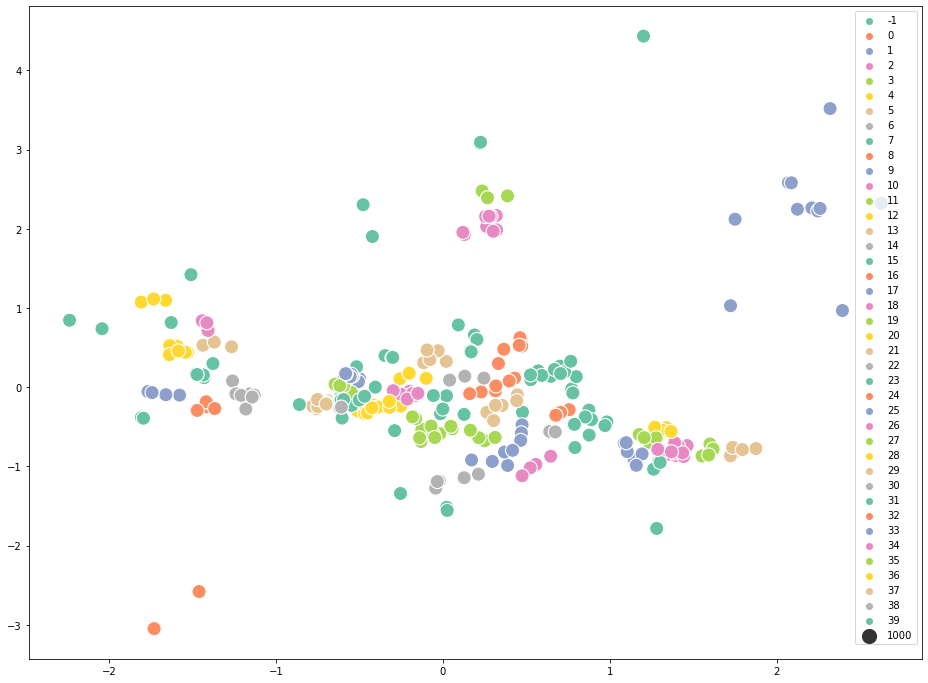

In [19]:
fig, ax = plt.subplots(figsize=(16, 12))

clu = HDBSCAN(min_cluster_size=4, cluster_selection_epsilon=0.2, max_cluster_size=20, alpha=0.2, min_samples=2)
clu.fit(C_train)
clusters = clu.labels_

col = sns.color_palette(palette="Set2", n_colors=np.unique(clusters).shape[0])
sns.scatterplot(x=C_train[:, 0], y=C_train[:, 1], hue=clusters, size=1000, sizes=(200,200), ax=ax, palette=col)



In [20]:
# bandwidth values to test
bandwidth = [10, 15, 20, 25, 30, 35, 40, 50, 75, 100, 125, 150, 200, 250]

# 1a. clustering of traning samples
clu = HDBSCAN(min_cluster_size=4, cluster_selection_epsilon=0.2, max_cluster_size=20, alpha=0.2, min_samples=2, store_centers='centroid')
clu.fit(C_train)

# extraction of cluster labels
samples_cluster = clu.labels_
clusters = np.unique(clu.labels_)

# create a matrix to store error for each bandwidth
# minus one, because "clusters" variable also stores outliers marked as "-1"
error_matrix = np.zeros((clusters.shape[0]-1, len(bandwidth)))

# 2a. tuning of bandwidth, for each cluster
for n_bandwidth_value, bandwidth_value in enumerate(bandwidth):

    for cluster_id in clusters:

        # 2b. if the sample is spatial outlier (not in any cluster, label =  -1)
        # the bandwidth is not tuned
        if cluster_id == -1:

            pass
        
        else:
            
            cluster_samples_number = samples_cluster[samples_cluster == cluster_id].shape[0]
            cluster_ind = np.nonzero(samples_cluster == cluster_id)[0]

            if cluster_samples_number > 4:

                # sample n samples so; cluster_samples_number - n = 4
                test_train_sample_ind = np.random.choice(cluster_ind, cluster_samples_number-4, replace=False)

            else:
                
                test_train_sample_ind = cluster_ind

            # calculate distance matrix from centroid of each cluster
            # the attribute "centroids_" of HDBSCAN class provides coordinates
            distance_matrix = np.sqrt((clu.centroids_[cluster_id, 0] - C_train[:, 0])**2 + (clu.centroids_[cluster_id, 1] - C_train[:, 1])**2)

            distance_indices = np.argpartition(distance_matrix, bandwidth_value)[:bandwidth_value]

            # and create a boolean matrix 
            boolean_matrix = np.full(C_train.shape[0], False)
            boolean_matrix[distance_indices] = True
            boolean_matrix[test_train_sample_ind] = False

            # 3a. create a model
            gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=8)
            # fit
            gdtr_model.fit(X_train[boolean_matrix], y_train[boolean_matrix])
            # and predict
            gdtr_prediction = gdtr_model.predict(X_train[test_train_sample_ind])

            cluster_rmse = mean_squared_error(y_train[test_train_sample_ind], gdtr_prediction, squared=False)
            error_matrix[cluster_id, n_bandwidth_value] = cluster_rmse



In [21]:
# find best bandwidth for each cluster

best_bandwidth = np.array(list(map(lambda x: bandwidth[x], np.argmin(error_matrix, axis=1))))

In [22]:
# prediciton for test samples are made similarly as in Multiscale Geographic Model
# 4a. firstly, for each testing sample we need to find cluster in which the sample belongs
# clustering is not a classification, we can not predict cluster label for unknow set of samples
# therefore, the samples are assigned closest cluster (distance to centroid or medoid) if condition of proximity is met
# proximity condition: the distance to closest cluster is lower than epsilon
# if condition is not met, the sample is outlier

# 4b. create a matrix to store closest cluster, -1 means outlier

closest_cluster = np.zeros((C_test.shape[0]))
cluster_selection_epsilon = 0.2

for n_location, location in enumerate(C_test):

    distance_matrix_to_clusters = np.sqrt((location[0] - clu.centroids_[:, 0])**2 + (location[1] - clu.centroids_[:, 1])**2)
    closest_cluster_ind = np.argmin(distance_matrix_to_clusters, axis=None)

    if distance_matrix_to_clusters[closest_cluster_ind] < cluster_selection_epsilon:

        closest_cluster[n_location] = closest_cluster_ind

    else:

        closest_cluster[n_location] = -1


In [23]:
# 5a. create a matrix to store predictions

prediction_matrix = np.zeros(C_test.shape[0])

# 5b. create a loop
for n_location, location in enumerate(C_test):

    id_cluster = int(closest_cluster[n_location])

    if id_cluster != -1:

        # get bandwidth from cluster
        bandwidth_value = best_bandwidth[id_cluster]

        # create a distance matrix, the distance is measured from centroid of cluster, not sample
        distance_matrix = np.sqrt((clu.centroids_[id_cluster, 0] - C_train[:, 0])**2 + (clu.centroids_[id_cluster, 1] - C_train[:, 1])**2)

        # get indices of bandwidth_value closest training samples
        distance_indices = np.argpartition(distance_matrix, bandwidth_value)[:bandwidth_value]
        
        # and create a boolean matrix 
        boolean_matrix = np.full(C_train.shape[0], False)
        boolean_matrix[distance_indices] = True

        # create a model
        gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=8)
        # fit
        gdtr_model.fit(X_train[boolean_matrix], y_train[boolean_matrix])
        # and predict
        gdtr_prediction = gdtr_model.predict(X_test[n_location].reshape(1, -1))

        # save prediction
        prediction_matrix[n_location] = gdtr_prediction

    else:
        pass

# 6a. Outliers
# outliers are trained on global model
    
# get indices of outlier samples
    
out_ind = np.where(closest_cluster == -1)

gdtr_model = DecisionTreeRegressor(max_depth=5, max_features=8)
gdtr_model.fit(X_train, y_train)
prediction_matrix[out_ind] = gdtr_model.predict(X_test[out_ind])

In [24]:
# calculate final rmse

rmse = mean_squared_error(y_test, prediction_matrix, squared=False)

print(f'RMSE for Multiscale Geographical model with clustering is: {rmse}')

RMSE for Multiscale Geographical model with clustering is: 9.880170817358634


### Region Growing Multiscale Geographical model (ReGrow MuG)

ReGrow MuG is a new experimental algorithm, which extends the idea of Geographically Weighted Regression and Multiscale Geographically Weighted Regression. The algorithm search for optimal region for each tested sample, from which are taken samples for traning. Compare to GWR/MS GWR the region may be highly irregular. This improvment aims to counter irregular influence of spatial non-stationarity and increase prediction accuracy.


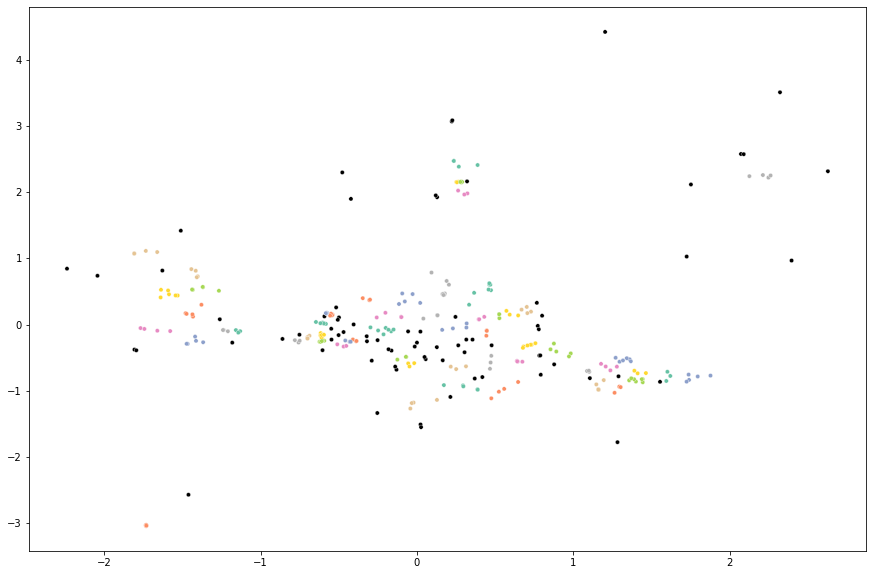

In [6]:
from sklearn.cluster import OPTICS
from sklearn.tree import DecisionTreeRegressor

# 1a. Clustering
# create OPTICS clustering class
clu = OPTICS(min_samples=3, max_eps=0.2, eps=0.2)
# fit coordinates of training samples
clu.fit(C_train)
# extract labels of clusters
clusters = clu.labels_

# 1b. Visualization of clusteting results
# create a matplolib plot 
fig, ax = plt.subplots(figsize=(15, 10))

col = sns.color_palette(palette="Set2", n_colors=np.unique(clusters).shape[0])
col[0] = (0,0,0)

sc = sns.scatterplot(x=C_train[:, 0], y=C_train[:, 1], hue=clusters, size=1000, ax=ax, palette=col)
sc.get_legend().set_visible(False)

# scatter plot of clusters for training samples
# each cluster have a distinct color
# outliers are black 

In [7]:
from sklearn.metrics import mean_squared_error

# 2a. Set parameters.
# PARAMETERS
max_test_tune_samples = 4
max_distance = 1

# store cluster region for each cluster
clusters_regions_label = []

# get labels for each cluster
unique_cluster = np.unique(clusters)

# cluster samples labelled -1, are outliers, we are not tuning them
# we drop the -1 value from cluster labels
outlier_ind = np.where(unique_cluster == -1)
unique_cluster = np.delete(unique_cluster, outlier_ind, axis=0) 

# get centroid for each cluster
# create a empty matrix
centroids = np.zeros((unique_cluster.shape[0], 2))

# calculate the centroids and insert them into empty centroid matrix
for n_cluster_label, cluster_label in enumerate(unique_cluster):
    centroid_cluster_label = np.mean(C_train[np.where(clusters == cluster_label)], axis=0)
    centroids[n_cluster_label,:] = centroid_cluster_label

# -----------------------LOOP----------------------------------
# 3a. loop cycle for each cluster
for n_cluster_label, cluster_label in enumerate(unique_cluster):

    # get samples, which belongs to the current cluster
    core_samples_ind = np.where(clusters == cluster_label)[0]
    # assing both training features and training targets 'core sector'
    core_samples_X_train_test = X_train[core_samples_ind,:]
    core_samples_y_train_test = y_train[core_samples_ind]

    # if the number of samples in the core sector is larger than desired number testing samples @max_test_tune_samples 
    # randomly sample core sector samples, rest will be assigned to traning samples
    # this action is performed only once for each cluster 
    if core_samples_ind.shape[0] > max_test_tune_samples:

        number_of_samples = core_samples_ind.shape[0] - max_test_tune_samples
        core_samples_train_ind = np.random.choice(core_samples_ind, number_of_samples, replace=False)
        core_samples_X_train = X_train[core_samples_train_ind,:]
        core_samples_y_train = y_train[core_samples_train_ind]

        core_samples_train_test_ind = np.delete(core_samples_ind, np.where(core_samples_ind == core_samples_train_ind))
        core_samples_X_train_test = X_train[core_samples_train_test_ind,:]
        core_samples_y_train_test = y_train[core_samples_train_test_ind]

    else:
        core_samples_X_train_test = X_train[core_samples_ind,:]
        core_samples_y_train_test = y_train[core_samples_ind]


    stopping_criterium = True

    # calculate the distance and order the other clusters
    # get centroid of core sector
    core_sector_centroid = centroids[n_cluster_label,:]

    # calculate the distance
    distance_matrix = np.sqrt((core_sector_centroid[0] - centroids[:, 0])**2  
                              + (core_sector_centroid[1] - centroids[:, 1])**2)
    # get indices of closest cluster (sort the distance matrix)
    distance_order = distance_matrix.argsort()
    closest_cluster_label = unique_cluster[distance_order[1]]

    core_cluster_label = [cluster_label, closest_cluster_label]
    
    # in case that cluster is alone, the samples are treated as outliers
    if distance_matrix[1] > max_distance:
        clusters_regions_label.append([-1])

    else:

        # add samples from closest cluster
        new_samples_train_ind =  np.where(clusters == closest_cluster_label)[0]
        new_samples_X_train = X_train[new_samples_train_ind, :]
        new_samples_y_train = y_train[new_samples_train_ind]

        try:
            core_samples_X_train = np.append(core_samples_X_train, new_samples_X_train, axis=0)
            core_samples_y_train = np.append(core_samples_y_train, new_samples_y_train, axis=0)
            
        except:
            core_samples_X_train = new_samples_X_train
            core_samples_y_train = new_samples_y_train


        # train model on training samples and test the model on train_test samples
        dtr_model = DecisionTreeRegressor(max_depth=5, max_features=6)
        dtr_model.fit(core_samples_X_train, core_samples_y_train)
        prediction = dtr_model.predict(core_samples_X_train_test)
        # calculate the base RMSE
        base_rmse =  mean_squared_error(core_samples_y_train_test, prediction, squared=False)
        
        # 4a. Iteratively growing region.
        # ------------------ LOOP -----------------------
        while stopping_criterium:

            # calculate distance matrix from centroid of core sector to any other cluster
            distance_matrix_loop = np.sqrt((centroids[core_cluster_label][:, 0].reshape((-1,1)) - centroids[:, 0])**2  
                          + (centroids[core_cluster_label][:, 1].reshape(-1,1) - centroids[:, 1])**2)
            
            # create mask matrix to prevent incorporating current clusters
            mask_matrix = np.zeros(distance_matrix_loop.shape, dtype=bool)
            mask_matrix[:, core_cluster_label] = True

            distance_matrix_loop_masked = np.ma.array(distance_matrix_loop, mask=mask_matrix)

            # find new closest cluster
            new_closest_cluster = divmod(distance_matrix_loop_masked.argmin(), distance_matrix_loop_masked.shape[1])[1]

            # add new samples from closest region
            new_samples_train_ind =  np.where(clusters == new_closest_cluster)[0]
            new_samples_X_train =  X_train[new_samples_train_ind, :]
            new_samples_y_train = y_train[new_samples_train_ind]

            core_samples_X_train = np.append(core_samples_X_train, new_samples_X_train, axis=0)
            core_samples_y_train = np.append(core_samples_y_train, new_samples_y_train, axis=0)

            # train and fit model
            dtr_model = DecisionTreeRegressor(max_depth=5, max_features=6)
            dtr_model.fit(core_samples_X_train, core_samples_y_train)
            prediction = dtr_model.predict(core_samples_X_train_test)

            # calculate new rmse
            new_rmse =  mean_squared_error(core_samples_y_train_test, prediction, squared=False)

            # if the new rmse is worse than previous one, the while cycle ends
            if new_rmse > base_rmse:

                stopping_criterium = False

            else:
                stopping_criterium = True
                core_cluster_label.append(new_closest_cluster)
    
    clusters_regions_label.append(core_cluster_label)


<ipython-input-7-27bc6b5e2003>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  core_samples_train_test_ind = np.delete(core_samples_ind, np.where(core_samples_ind == core_samples_train_ind))
<ipython-input-7-27bc6b5e2003>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  core_samples_train_test_ind = np.delete(core_samples_ind, np.where(core_samples_ind == core_samples_train_ind))
<ipython-input-7-27bc6b5e2003>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  core_samples_train_test_ind = np.delete(core_samples_ind, np.where(core_samples_ind == core_samples_train_ind))
<ipython-input-7-27bc6b5e2003>:47: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  core_samples_train_test_ind = np.delete(core_samples_ind, np.where(core_samples_ind == core_samples_train_ind))
<ipython-input-7-27bc6b5e2003>:47: Depre

In [11]:
# 5. Find closest cluster to each tested sample.

# Parameter max distance to cluster
# regulates assigment to outliers
max_distance_to_cluster = 0.4


closest_cluster = np.zeros((C_test.shape[0]))

for n_location, location in enumerate(C_test):

    distance_matrix_to_clusters = np.sqrt((location[0] - centroids[:, 0])**2 + (location[1] - centroids[:, 1])**2)
    closest_cluster_ind = np.argmin(distance_matrix_to_clusters, axis=None)

    if distance_matrix_to_clusters[closest_cluster_ind] < max_distance_to_cluster:

        closest_cluster[n_location] = closest_cluster_ind

    else:

        closest_cluster[n_location] = -1

In [80]:
# 6a. create a matrix to store predictions

prediction_matrix = np.zeros(C_test.shape[0])

# 6b. create a loop
for n_location, location in enumerate(C_test):

    id_cluster = int(closest_cluster[n_location])

    if id_cluster != -1:

        # get cluster region for each testing sample
        cluster_region = clusters_regions_label[id_cluster]

        # get indices of training samples 
        cluster_samples_ind = list(map(lambda x: np.where(clusters == x) , cluster_region))
        cluster_samples_ind = list(map(lambda x: x[0].tolist(), cluster_samples_ind))
        cluster_samples_ind = [x for xs in cluster_samples_ind for x in xs]

        # get training samples
        X_train_region = X_train[cluster_samples_ind,:]
        y_train_region = y_train[cluster_samples_ind]

        # create a model
        dt_model = DecisionTreeRegressor(max_depth=5, max_features=8)
        # fit
        dt_model.fit(X_train_region, y_train_region)
        # and predict
        dt_prediction = dt_model.predict(X_test[n_location].reshape(1, -1))

        # save prediction
        prediction_matrix[n_location] = dt_prediction

    else:
        pass


# 7a. Outliers
# outliers are trained on global model
    
# get indices of outlier samples
    
out_ind = np.where(closest_cluster == -1)

dt_model = DecisionTreeRegressor(max_depth=5, max_features=8)
dt_model.fit(X_train, y_train)

dt_outliers_prediction = dt_model.predict(X_test[out_ind])
prediction_matrix[out_ind] = dt_outliers_prediction

In [82]:
# 8. calculate final rmse

rmse = mean_squared_error(y_test, prediction_matrix, squared=False)

print(f'RMSE for Region Growing Multiscale Geographical model is: {rmse}')

RMSE for Region Growing Multiscale Geographical model is: 12.799632679465867
